In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
original_data = pd.read_table('results_renamed.tsv')

In [3]:
data = original_data.copy()

In [4]:
data["label_freq"] = (
    data.loc[:, data.columns.str.endswith("label_frequency_estimates_")]
    .map(lambda x: np.fromstring(x[1:-1], sep=",") if isinstance(x, str) else x)
)

data["avg_label_freq"] = data["label_freq"].copy()
data.loc[~data.avg_label_freq.isna(), "avg_label_freq"] = (
    data.loc[~data.avg_label_freq.isna(), "avg_label_freq"].map(lambda x: x.mean())
)
data["avg_label_freq"].head()

0    0.616476
1    0.616476
2    0.631396
3    0.623751
4    0.623751
Name: avg_label_freq, dtype: object

In [5]:
data = data.loc[data.level.str.match(r"^\d+$")]
data.loc[:, "level"] = data.loc[:, "level"].astype(int)

In [6]:

data = data.set_index([
    "cv.fold", "estimator.name", "dataset.name", "avg_label_freq", "level",
])
score_columns_mask = data.columns.str.match(r"results\.(test|train).*")
data = data.loc[:, score_columns_mask]

In [7]:
metric = (
    data.columns#[score_columns_mask]
    .str.removeprefix("results.")
    .str.removeprefix("train_")
    .str.removeprefix("test_")
    .str.removesuffix("_oob")
    .str.removesuffix("_masked")
    .rename("metric")
    # .to_series()
    # .set_axis(expected_best.index)
)

data.columns = pd.MultiIndex.from_tuples(
    ((m, s.replace("_" + m, "").removeprefix("results."))
    for m, s in zip(metric, data.columns)),
    names=("metric", "scorer"),
)

In [8]:
data = data.loc[:, ["average_precision_micro", "roc_auc_micro", "neg_hamming_loss_micro"]]
data = data.sort_index(axis=1)

In [80]:
data

metric                                                                    average_precision_micro  \
scorer                                                                                       test   
cv.fold estimator.name                 dataset.name  avg_label_freq level                           
4       cascade_lc_tree_embedder       VirusGO       0.616476       9                    0.932958   
                                                                    10                   0.925580   
1       cascade_lc_tree_embedder       VirusGO       0.631396       3                    0.819666   
2       cascade_lc_tree_embedder       VirusGO       0.623751       2                    0.950717   
                                                                    1                    0.919965   
...                                                                                           ...   
3       cascade_lc_tree_embedder_proba Gram_negative 0.842583       3                    0.970617   
                                                                    2                    0.972551   
                                                                    1                    0.966532   
0       cascade_lc_tree_embedder_proba Gram_negative 0.852453       4                    0.974691   
                                                                    5                    0.970840   

metric                                                                                 \
scorer                                                                    test_masked   
cv.fold estimator.name                 dataset.name  avg_label_freq level               
4       cascade_lc_tree_embedder       VirusGO       0.616476       9             NaN   
                                                                    10            NaN   
1       cascade_lc_tree_embedder       VirusGO       0.631396       3             NaN   
2       cascade_lc_tree_embedder       VirusGO       0.623751       2             NaN   
                                                                    1             NaN   
...                                                                               ...   
3       cascade_lc_tree_embedder_proba Gram_negative 0.842583       3             NaN   
                                                                    2             NaN   
                                                                    1             NaN   
0       cascade_lc_tree_embedder_proba Gram_negative 0.852453       4             NaN   
                                                                    5             NaN   

metric                                                                              \
scorer                                                                    test_oob   
cv.fold estimator.name                 dataset.name  avg_label_freq level            
4       cascade_lc_tree_embedder       VirusGO       0.616476       9          NaN   
                                                                    10         NaN   
1       cascade_lc_tree_embedder       VirusGO       0.631396       3          NaN   
2       cascade_lc_tree_embedder       VirusGO       0.623751       2          NaN   
                                                                    1          NaN   
...                                                                            ...   
3       cascade_lc_tree_embedder_proba Gram_negative 0.842583       3          NaN   
                                                                    2          NaN   
                                                                    1          NaN   
0       cascade_lc_tree_embedder_proba Gram_negative 0.852453       4          NaN   
                                                                    5          NaN   

metric                                                                               \
scorer                                        

scorer
train        0.189091
train_oob    0.178182
dtype: float64


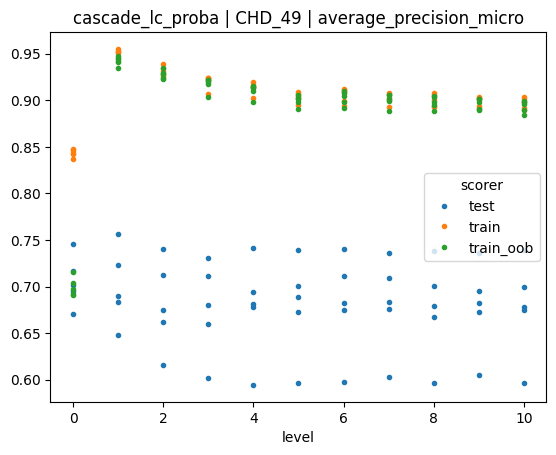

In [21]:
for gname, g in data.groupby(level=["estimator.name", "dataset.name"]):
    for gname2, g2 in g.T.groupby(level="metric"):
        g2 = g2.T.droplevel("metric", axis=1).reset_index().sort_values("level")
        # g2[g2["cv.fold"] == 2].plot(  # NOTE: Each fold results are drastically different
        g2.plot(
            x="level",
            y=["test", "train", "train_oob"],
            title=f"{' | '.join(gname)} | {gname2}",
            style=".",
        )

        print(
            g2.groupby("cv.fold").apply(
                # lambda x: x[["train_internal", "train_oob_internal"]].corrwith(
                lambda x: x[["train", "train_oob"]].corrwith(
                    g2.test, method="spearman", numeric_only=True
                )
            ).abs().mean()
        )
        break
    break